In [1]:
# Import modules and connect to a database
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

%load_ext sql
%sql sqlite://

%matplotlib inline

In [2]:
# Load the drivers.csv file and create a table
drivers = pd.read_csv('formula-1-race-data-19502017/drivers.csv', encoding='ISO-8859-1')
%sql PERSIST drivers

 * sqlite://


'Persisted drivers'

## Table vs DataFrame
Notice the similarities between the two.

In [3]:
%sql SELECT * FROM drivers LIMIT 5;

 * sqlite://
Done.


index,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,07/01/1985,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,None,HEI,Nick,Heidfeld,10/05/1977,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6.0,ROS,Nico,Rosberg,27/06/1985,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14.0,ALO,Fernando,Alonso,29/07/1981,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,None,KOV,Heikki,Kovalainen,19/10/1981,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [4]:
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,07/01/1985,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,NaN,HEI,Nick,Heidfeld,10/05/1977,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6.0,ROS,Nico,Rosberg,27/06/1985,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14.0,ALO,Fernando,Alonso,29/07/1981,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,NaN,KOV,Heikki,Kovalainen,19/10/1981,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


## Problem 1
Find all Spanish drivers who were born after 1980. 

The "dob" column contains a string, so we can take a sub-string and compare it with '1980'.

In [16]:
%%sql 

SELECT forename, surname, dob 
  FROM drivers 
 WHERE nationality = 'Spanish' 
   AND substr(dob,7) > '1980';

 * sqlite://
Done.


forename,surname,dob
Fernando,Alonso,29/07/1981
Jaime,Alguersuari,23/03/1990
Carlos,Sainz,01/09/1994
Roberto,Merhi,22/03/1991


## Problem 2
Find the number of drivers for each nationality.

Remove entries where count <= 10 and create a bar plot.

In [50]:
%%sql 

SELECT nat, count
  FROM ( 
      SELECT nationality as nat, 
             COUNT(*) as count 
      FROM drivers 
      GROUP BY nationality
     ) 
WHERE count > 10;

 * sqlite://
Done.


nat,count
American,157
Argentine,24
Australian,17
Austrian,15
Belgian,23
Brazilian,31
British,162
Canadian,13
Dutch,17
French,73


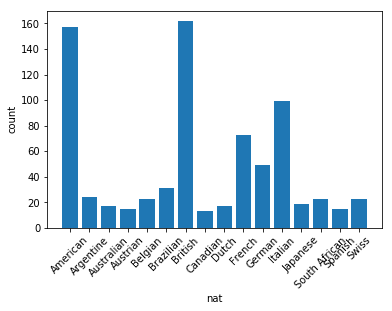

In [51]:
# Create a bar graph from the query result
_.bar();

## Problem 3
Find the most successful constructors in F1 by race wins and create a pie chart.

In [9]:
# Load two more tables
cons = pd.read_csv('formula-1-race-data-19502017/constructors.csv', encoding='ISO-8859-1')
%sql PERSIST cons

res = pd.read_csv('formula-1-race-data-19502017/results.csv', encoding='ISO-8859-1')
%sql PERSIST res

 * sqlite://
 * sqlite://


'Persisted res'

In [10]:
# Show the column names of these tables
print(cons.columns)
print(res.columns)

Index(['constructorId', 'constructorRef', 'name', 'nationality', 'url',
       'Unnamed: 5'],
      dtype='object')
Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')


In [22]:
%%sql

-- Find the number of race wins for each constructor, but only keep the top 10

SELECT name, COUNT(*) count
  FROM res R
       JOIN cons C
       ON R.constructorId=C.constructorId
 WHERE position=1
 GROUP BY R.constructorId
 ORDER BY count DESC
 LIMIT 10;

 * sqlite://
Done.


name,count
Ferrari,230
McLaren,178
Williams,114
Mercedes,76
Red Bull,55
Team Lotus,45
Renault,35
Benetton,27
Tyrrell,23
Brabham,23


In [12]:
# We can do the same with Pandas to verify the results
df = res[res['position'] == 1]
df = df.groupby('constructorId').agg('count')
df = df.join(cons.set_index('constructorId'))

In [13]:
# Both methods produced the same result, but which one is easier to read?
df = df[['name', 'resultId']].sort_values('resultId', ascending=False)
df = df.head(10)
df

,name,resultId
constructorId,,
6,Ferrari,230
1,McLaren,178
3,Williams,114
131,Mercedes,76
9,Red Bull,55
32,Team Lotus,45
4,Renault,35
22,Benetton,27
25,Tyrrell,23


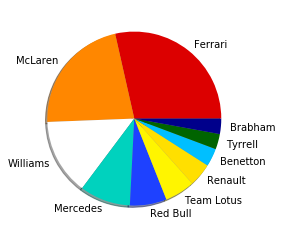

In [14]:
'''
Now we can produce a pie chart using the DataFrame
Matplotlib allows us to specify colors in the pie chart
Credits to www.f1colours.com and
www.reddit.com/r/formula1/comments/arxt0r/f1_2019_team_colors_hex_codes/
for the team colors
'''

colors = ['#DC0000', '#FF8700', '#FFFFFF', '#00D2BE', '#1E41FF', 
          '#FFF500', '#FFDF00', '#00BFFF', '#006400', '#00008B']

plt.pie(df['resultId'], labels=df['name'], colors=colors, shadow=True);

## Problem 4
Find the most successful constructors in F1 by win rate

In [23]:
%%sql 

-- Find number of race wins and race entries and divide

  WITH race_wins(consId, wins) AS 
       (SELECT constructorId, COUNT(*)
       FROM res
       WHERE position=1
       GROUP BY constructorId)
    
SELECT name, round(W.wins*1.0/COUNT(*), 3) win_rate
  FROM cons C
       JOIN res R
       ON C.constructorId=R.constructorId
        
       JOIN race_wins W
       ON R.constructorId=W.consId
 GROUP BY R.constructorId
 ORDER BY win_rate DESC
 LIMIT 10;

 * sqlite://
Done.


name,win_rate
Brawn,0.235
Matra-Ford,0.225
Mercedes,0.215
Vanwall,0.141
Watson,0.136
Epperly,0.118
Red Bull,0.112
McLaren,0.11
Ferrari,0.107
Brabham-Repco,0.104


## Problem 5
Is the number of races each season increasing?

In [24]:
# Load races.csv as a DataFrame
races = pd.read_csv('formula-1-race-data-19502017/races.csv', encoding='ISO-8859-1')
races.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [25]:
# Group by 'year'
races = races.groupby('year').aggregate('count').reset_index()

In [26]:
# Find a best fit line
fit = stats.linregress(races['year'], races['raceId'])
races['fit'] = fit.slope * races['year'] + fit.intercept

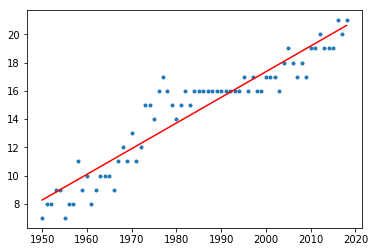

In [27]:
# Take a look at the results, is the slope increasing?
# We can find out by performing a hypothesis test
plt.plot(races['year'], races['raceId'], '.')
plt.plot(races['year'], races['fit'], 'r-')

In [28]:
# Chances of the slope being zero...
fit.pvalue

5.430315536260765e-34

(array([ 5.,  8., 16., 11., 13.,  8.,  3.,  2.,  2.,  1.]),
 array([-2.26776276, -1.65865059, -1.04953842, -0.44042626,  0.16868591,
         0.77779808,  1.38691024,  1.99602241,  2.60513458,  3.21424674,
         3.82335891]),
 <a list of 10 Patch objects>)

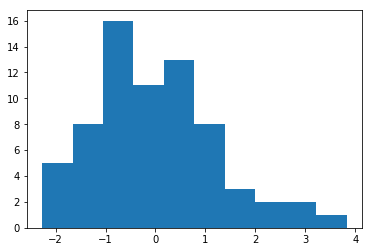

In [29]:
# Plot a histogram of the residuals
# Does this look reasonably normal?
plt.hist(races['raceId'] - races['fit'])